# WarmStartQAOA-Epsilon

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))

import numpy as np
import pandas as pd
import qiskit
provider = qiskit.IBMQ.load_account()

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, GoemansWilliamsonOptimizer
from qiskit_optimization.algorithms import RecursiveMinimumEigenOptimizer, IntermediateResult
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# ---- Define graph and MaxCut ----
#graph = load_nx_graph_from(f"../landscape/simulator/comparison_3_reg/data/graph_3_reg_6_9_w_01.txt")
#opt_max_cut = -31
#graph = load_nx_graph_from(f"../landscape/simulator/comparison_3_reg/data/graph_3_reg_4_6_w_01.txt")
#opt_max_cut = -20

#graph = load_nx_graph_from(f"../landscape/simulator/comparison_3_reg/data/graph_3_reg_8_12_w_01.txt")
#opt_max_cut = -53

#graph = load_nx_graph_from(f"../landscape/simulator/comparison_3_reg/data/graph_3_reg_10_15_w_01.txt")
#opt_max_cut = -74


graph = generate_butterfly_graph(with_weights=True)
opt_max_cut = -35
max_cut = Maxcut(graph, opt_max_cut)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [3]:
eval_num = 50
maxiter = 100
shots = 1024

## Simulator

In [4]:
quantum_instance = QuantumInstance(
                                    backend=Aer.get_backend('qasm_simulator'),
                                    shots=shots
                                    )

In [5]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_optimization.algorithms import WarmStartQAOAFactory, MinimumEigenOptimizer
import numpy as np
from qiskit.circuit import (
    Parameter,
    ParameterVector,
    QuantumRegister,
    QuantumCircuit,
    ParameterExpression,
)

In [18]:
class MyWarmStartQAOAFactory(WarmStartQAOAFactory):
    def create_mixer(self, initial_variables: List[float]) -> QuantumCircuit:
        """
        Creates an evolved mixer circuit as Ry(theta)Rz(-2beta)Ry(-theta).
        Args:
            initial_variables: Already created initial variables.
        Returns:
            A quantum circuit to be used as a mixer in QAOA.
        """
        circuit = QuantumCircuit(len(initial_variables))
        beta = Parameter("beta")
        #print(len(initial_variables))
        
        #here is the rproblem!! 

        for index, relaxed_value in enumerate(initial_variables):
            theta = 2 * np.arcsin(np.sqrt(relaxed_value))
            
            circuit.ry(-theta, index)
            circuit.rz(-2*beta, index)
            circuit.ry(theta, index)

        return circuit


In [7]:
qaoa = QAOA(optimizer = COBYLA(maxiter=maxiter),
            quantum_instance = quantum_instance,
                
              initial_point=[np.pi/2, 1., 1.],
              reps=2, 
            )

In [8]:


def run_ws_qaoa(max_cut, quantum_instance, epsilon):
    
    qaoa = QAOA(optimizer = COBYLA(maxiter=maxiter),
                quantum_instance = quantum_instance,
              
              
           #  initial_point=[np.pi/2, 0.],
           #   reps=1,
               
                
              initial_point=[np.pi/2, 1., 1.],
              reps=2,
                
             #  initial_point=[np.pi/2, 0., 0., 0.],
             #   reps=3,
               
            # not working 
             #initial_point=[np.pi/2, 0., 0., 0., 0.],
            # reps=4,
                
            #initial_point=[ np.pi/2, 0., 0., 0., 0.],
            # reps=4,
                
           # initial_point=[np.pi/2, 0.,0.,0., 0., 0.],
           # reps=5,
                
          # initial_point=[np.pi/2, 0.,0.,0.,0., 0., 0.],
           # reps=6,
               
               )
    

    ws_factory = MyWarmStartQAOAFactory(epsilon)
    ws_factory.p = qaoa._reps
    ws_qaoa = WarmStartQAOAOptimizer(pre_solver=GoemansWilliamsonOptimizer(2),
                                     relax_for_pre_solver=False, qaoa=qaoa,
                                     num_initial_solutions=1, epsilon=epsilon,
                                     warm_start_factory=ws_factory,
                                    )

    
    result = ws_qaoa.solve(max_cut.to_qubo())
    
    
    # construct circuit 
   # param_dict = dict(zip(ws_qaoa._min_eigen_solver._ansatz_params, ws_qaoa._min_eigen_solver._initial_point))  # type: Dict
   # circuit = ws_qaoa._min_eigen_solver.ansatz.assign_parameters(param_dict)
   # circuit.draw('mpl')
    print(qaoa._ansatz.qasm())
    circuit = None
    print(qaoa._ansatz.parameters)
    for k in qaoa._ansatz._parameter_table.keys():
        print(k)
        print(qaoa._ansatz._parameter_table[k])
        print()
    #print(qaoa._ansatz._parameter_table[Parameter(beta)])
    qaoa._ansatz.draw('mpl')
    
    
    
    exp_value, _, approximation_ratio = max_cut.analyse_evaluation(result, print_output=False)
   
    return exp_value, approximation_ratio, circuit

In [10]:
m, r, c = run_ws_qaoa(max_cut, quantum_instance, epsilon=0.25)

QasmError: 'Cannot represent circuits with unbound parameters in OpenQASM 2.'

In [ ]:
m, r, c = run_ws_qaoa(max_cut, quantum_instance, epsilon=0.25)

In [ ]:
def run_qaoa(qaoa, qubo):
    algorithm = MinimumEigenOptimizer(qaoa)
    result = algorithm.solve(qubo)
    optimal_parameters = qaoa.optimal_params
    return result, optimal_parameters

In [579]:
qas= """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
ry(pi/3) q[0];
ry(2*pi/3) q[1];
ry(pi/3) q[2];
cx q[2],q[1];
rz(0.0) q[1];
cx q[2],q[1];
ry(2*pi/3) q[3];
cx q[3],q[0];
rz(0.0) q[0];
cx q[3],q[0];
ry(pi/3) q[4];
cx q[4],q[0];
rz(0.0) q[0];

cx q[4],q[0];
ry(pi/3) q[0];
rz(-pi) q[0];
ry(-pi/3) q[0];
cx q[4],q[1];
rz(0.0) q[1];
cx q[4],q[1];
ry(2*pi/3) q[1];
rz(-pi) q[1];
ry(-2*pi/3) q[1];
cx q[4],q[2];
rz(0.0) q[2];
cx q[4],q[2];
ry(pi/3) q[2];
rz(-pi) q[2];
ry(-pi/3) q[2];
cx q[2],q[1];
rz(0.0) q[1];
cx q[2],q[1];
cx q[4],q[3];
rz(0.0) q[3];
cx q[4],q[3];
ry(2*pi/3) q[3];
rz(-pi) q[3];
ry(-2*pi/3) q[3];
cx q[3],q[0];
rz(0.0) q[0];
cx q[3],q[0];
ry(pi/3) q[4];
rz(-pi) q[4];
ry(-pi/3) q[4];
cx q[4],q[0];
rz(0.0) q[0];

cx q[4],q[0];
ry(pi/3) q[0];
rz(0) q[0];
ry(-pi/3) q[0];
cx q[4],q[1];
rz(0.0) q[1];
cx q[4],q[1];
ry(2*pi/3) q[1];
rz(0) q[1];
ry(-2*pi/3) q[1];
cx q[4],q[2];
rz(0.0) q[2];
cx q[4],q[2];
ry(pi/3) q[2];
rz(0) q[2];
ry(-pi/3) q[2];
cx q[2],q[1];
rz(0.0) q[1];
cx q[2],q[1];
cx q[4],q[3];
rz(0.0) q[3];
cx q[4],q[3];
ry(2*pi/3) q[3];
rz(0) q[3];
ry(-2*pi/3) q[3];
cx q[3],q[0];
rz(0.0) q[0];
cx q[3],q[0];
ry(pi/3) q[4];
rz(0) q[4];
ry(-pi/3) q[4];
cx q[4],q[0];
rz(0.0) q[0];

cx q[4],q[0];
ry(pi/3) q[0];
rz(0) q[0];
ry(-pi/3) q[0];
cx q[4],q[1];
rz(0.0) q[1];
cx q[4],q[1];
ry(2*pi/3) q[1];
rz(0) q[1];
ry(-2*pi/3) q[1];
cx q[4],q[2];
rz(0.0) q[2];
cx q[4],q[2];
ry(pi/3) q[2];
rz(0) q[2];
ry(-pi/3) q[2];
cx q[2],q[1];
rz(0.0) q[1];
cx q[2],q[1];
cx q[4],q[3];
rz(0.0) q[3];
cx q[4],q[3];
ry(2*pi/3) q[3];
rz(0) q[3];
ry(-2*pi/3) q[3];
cx q[3],q[0];
rz(0.0) q[0];
cx q[3],q[0];
ry(pi/3) q[4];
rz(0) q[4];
ry(-pi/3) q[4];
cx q[4],q[0];
rz(0.0) q[0];

cx q[4],q[0];
ry(pi/3) q[0];
rz(0) q[0];
ry(-pi/3) q[0];
cx q[4],q[1];
rz(0.0) q[1];
cx q[4],q[1];
ry(2*pi/3) q[1];
rz(0) q[1];
ry(-2*pi/3) q[1];
cx q[4],q[2];
rz(0.0) q[2];
cx q[4],q[2];
ry(pi/3) q[2];
rz(0) q[2];
ry(-pi/3) q[2];
cx q[4],q[3];
rz(0.0) q[3];
cx q[4],q[3];
ry(2*pi/3) q[3];
rz(0) q[3];
ry(-2*pi/3) q[3];
ry(pi/3) q[4];
rz(0) q[4];
ry(-pi/3) q[4];


"""

In [580]:
qas2 = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
ry(pi/3) q[0];
ry(2*pi/3) q[1];
ry(pi/3) q[2];
cx q[2],q[1];
rz(0.0) q[1];
cx q[2],q[1];
ry(2*pi/3) q[3];
cx q[3],q[0];
rz(0.0) q[0];
cx q[3],q[0];
ry(pi/3) q[4];
cx q[4],q[0];
rz(0.0) q[0];

cx q[4],q[0];
ry(pi/3) q[0];
 rz(-pi) q[0];
ry(-pi/3) q[0];
cx q[4],q[1];
rz(0.0) q[1];
cx q[4],q[1];
ry(2*pi/3) q[1];
 rz(-pi) q[1];
ry(-2*pi/3) q[1];
cx q[4],q[2];
rz(0.0) q[2];
cx q[4],q[2];
ry(pi/3) q[2];
 rz(-pi) q[2];
ry(-pi/3) q[2];
cx q[2],q[1];
rz(0.0) q[1];
cx q[2],q[1];
cx q[4],q[3];
rz(0.0) q[3];
cx q[4],q[3];
ry(2*pi/3) q[3];
 rz(-pi) q[3];
ry(-2*pi/3) q[3];
cx q[3],q[0];
rz(0.0) q[0];
cx q[3],q[0];
ry(pi/3) q[4];
 rz(-pi) q[4];
ry(-pi/3) q[4];
cx q[4],q[0];
rz(0.0) q[0];

cx q[4],q[0];
ry(pi/3) q[0];
rz(0) q[0];
ry(-pi/3) q[0];
cx q[4],q[1];
rz(0.0) q[1];
cx q[4],q[1];
ry(2*pi/3) q[1];
rz(0) q[1];
ry(-2*pi/3) q[1];
cx q[4],q[2];
rz(0.0) q[2];
cx q[4],q[2];
ry(pi/3) q[2];
rz(0) q[2];
ry(-pi/3) q[2];
cx q[4],q[3];
rz(0.0) q[3];
cx q[4],q[3];
ry(2*pi/3) q[3];
rz(0) q[3];
ry(-2*pi/3) q[3];
ry(pi/3) q[4];
rz(0) q[4];
ry(-pi/3) q[4];

"""

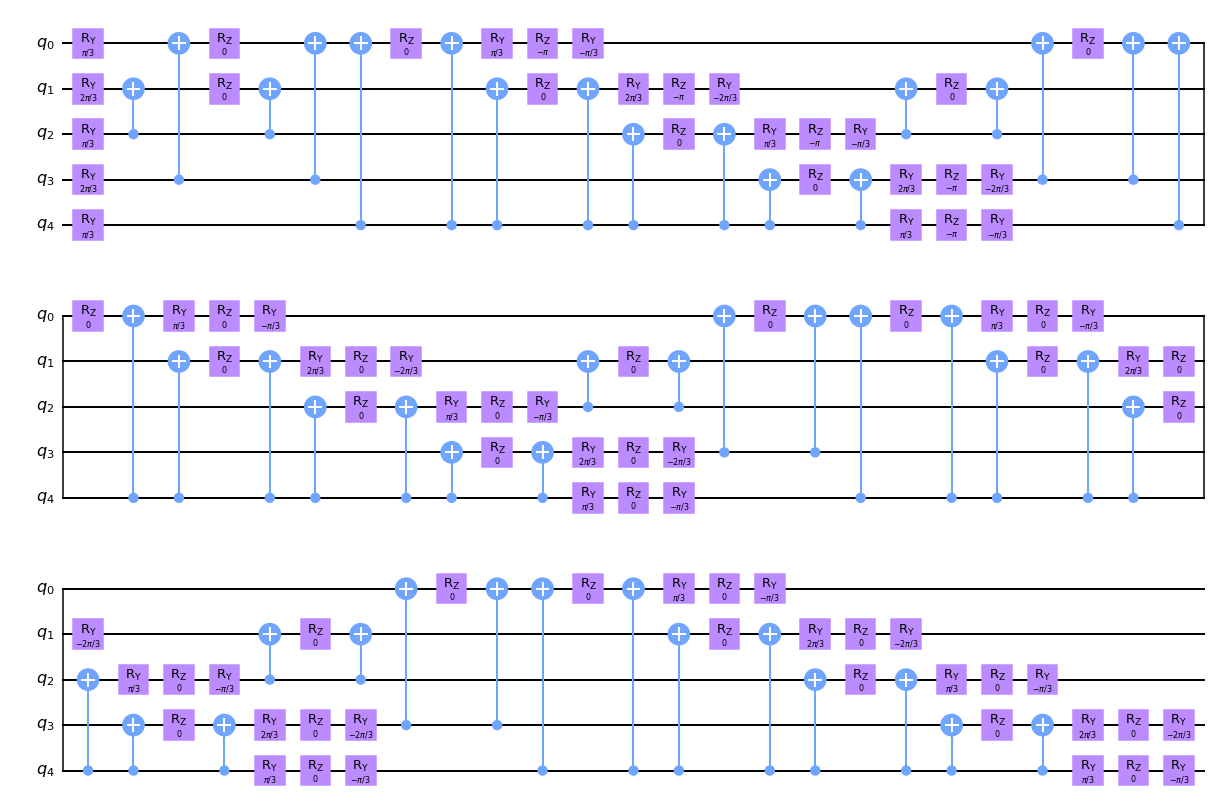

In [581]:
ci = QuantumCircuit.from_qasm_str(qas)
ci.draw('mpl')

In [582]:
ci.measure_all()

In [583]:
quantum_instance.execute(ci)

Result(backend_name='qasm_simulator', backend_version='0.8.2', qobj_id='25b3198f-4802-46dd-a27c-4b9c1b143ac6', job_id='f677d086-cc88-4410-98c5-17c1e4d6795d', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x15': 1024}), header=QobjExperimentHeader(clbit_labels=[['meas', 0], ['meas', 1], ['meas', 2], ['meas', 3], ['meas', 4]], creg_sizes=[['meas', 5]], global_phase=1.5707963267948966, memory_slots=5, metadata=None, n_qubits=5, name='circuit-29193789', qreg_sizes=[['q', 5]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4]]), status=DONE, seed_simulator=2747244051, metadata={'parallel_shots': 1, 'method': 'statevector', 'parallel_state_update': 384, 'measure_sampling': True, 'fusion': {'applied': False, 'max_fused_qubits': 5, 'enabled': True, 'threshold': 14}}, time_taken=0.0020947780000000003)], date=2021-09-12T12:17:26.847093, status=COMPLETED, status=QobjHeader(backend_name='qasm_simulator', backend_vers

In [9]:
from typing import Optional, List, Callable, Union, Dict, Tuple
import logging
import warnings
from time import time
import numpy as np

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import RealAmplitudes
from qiskit.providers import BaseBackend
from qiskit.providers import Backend
from qiskit.opflow import (
    OperatorBase,
    ExpectationBase,
    ExpectationFactory,
    StateFn,
    CircuitStateFn,
    ListOp,
    I,
    CircuitSampler,
)
from qiskit.opflow.gradients import GradientBase
from qiskit.utils.validation import validate_min
from qiskit.utils.backend_utils import is_aer_provider
from qiskit.utils.deprecation import deprecate_function
from qiskit.utils import QuantumInstance, algorithm_globals

class MyQAOA(QAOA):
    
    
    def _get_eigenstate(self, optimal_parameters) -> Union[List[float], Dict[str, int]]:
        """Get the simulation outcome of the ansatz, provided with parameters."""
        
        for opti in optimal_parameters:
            if opti.name == "beta":
                optimal_parameters[opti] = np.pi/2
            else:
                optimal_parameters[opti] = 0.0
                
        
        #print(optimal_parameters)
        
        wave_function = self.ansatz.bind_parameters(optimal_parameters)
        
         # print(f"my: {wave_function.qasm()}")
        
        
        temp = []
        
        counter = 0
        qasm = wave_function.qasm()
        #print(qasm)
        qasm_new = ""
        for line in qasm.split('\n'):
            if 'rz(-pi)' in line:
                counter += 1
                if line in temp:
                    line = line.replace('-pi','0.0')
                else:
                    temp.append(line)
                 
               # if counter > wave_function.num_qubits :
                    #print("changed")
               #     line = line.replace('-pi','46.0')
            qasm_new += line + "\n"
        
        #print(qasm_new)   
        #print(f"counter: {counter}")
        #print(wave_function.num_qubits)
        
        wave_function = QuantumCircuit.from_qasm_str(qasm_new)
        #print(wave_function)
        #wave_function.draw('mpl')
        state_fn = self._circuit_sampler.convert(StateFn(wave_function)).eval()
        if self.quantum_instance.is_statevector:
            state = state_fn.primitive.data  # VectorStateFn -> Statevector -> np.array
        else:
            state = state_fn.to_dict_fn().primitive  # SparseVectorStateFn -> DictStateFn -> dict

        return state

    def construct_expectation(
        self,
        parameter: Union[List[float], List[Parameter], np.ndarray],
        operator: OperatorBase,
        return_expectation: bool = False,
    ) -> Union[OperatorBase, Tuple[OperatorBase, ExpectationBase]]:
        r"""
        Generate the ansatz circuit and expectation value measurement, and return their
        runnable composition.
        Args:
            parameter: Parameters for the ansatz circuit.
            operator: Qubit operator of the Observable
            return_expectation: If True, return the ``ExpectationBase`` expectation converter used
                in the construction of the expectation value. Useful e.g. to compute the standard
                deviation of the expectation value.
        Returns:
            The Operator equalling the measurement of the ansatz :class:`StateFn` by the
            Observable's expectation :class:`StateFn`, and, optionally, the expectation converter.
        Raises:
            AlgorithmError: If no operator has been provided.
            AlgorithmError: If no expectation is passed and None could be inferred via the
                ExpectationFactory.
        """
        if operator is None:
            raise AlgorithmError("The operator was never provided.")

        self._check_operator_ansatz(operator)

        # if expectation was never created, try to create one
        if self.expectation is None:
            expectation = ExpectationFactory.build(
                operator=operator,
                backend=self.quantum_instance,
                include_custom=self._include_custom,
            )
        else:
            expectation = self.expectation

      #  print(self._ansatz_params)
        param_dict = dict(zip(self._ansatz_params, parameter)) 
        #print(param_dict)# type: Dict
        wave_function = self.ansatz.assign_parameters(param_dict)
        wave_function = wave_function.bind_parameters(self.initial_point)

        temp = []
       # print(f"my: {wave_function.qasm()}")
        counter = 0
        qasm = wave_function.qasm()
        qasm_new = ""
        for line in qasm.split('\n'):
            if 'rz(-pi)' in line:
                counter += 1
                if line in temp:
                    line = line.replace('-pi','0.0')
                else:
                    temp.append(line)
            qasm_new += line + "\n"
        
        #print(qasm_new)   
        #print(f"counter: {counter}")
        #print(operator.num_qubits)
        
        wave_function = QuantumCircuit.from_qasm_str(qasm_new)
        
        observable_meas = expectation.convert(StateFn(operator, is_measurement=True))
        ansatz_circuit_op = CircuitStateFn(wave_function)
        expect_op = observable_meas.compose(ansatz_circuit_op).reduce()

        if return_expectation:
            return expect_op, expectation

        return expect_op
    
    



In [14]:
def run_ws_qaoa_2(max_cut, quantum_instance, epsilon):
    qaoa = MyQAOA(optimizer = COBYLA(maxiter=maxiter),
                quantum_instance = quantum_instance,reps=1, initial_point=[np.pi/2,0])

    #epsilon = 0.24

    ws_factory = MyWarmStartQAOAFactory(epsilon)
    ws_factory.p = qaoa._reps
    ws_qaoa = WarmStartQAOAOptimizer(pre_solver=GoemansWilliamsonOptimizer(5),
                                     relax_for_pre_solver=False, qaoa=qaoa,
                                     num_initial_solutions=5, epsilon=epsilon,
                                     warm_start_factory=ws_factory,
                                    )


    result = ws_qaoa.solve(max_cut.to_qubo())
    exp_value, _, approximation_ratio = max_cut.analyse_evaluation(result, print_output=False)
    
    return exp_value, approximation_ratio

In [19]:
exp_medians = []
ar_medians = []
eps = []

# epsilon from 0 until 0.5 in 50 steps  
for e in range(0,51, 1):
    epsilon = e * 0.01
    temp_exp = []
    temp_ar = []
    
    # execute warmstart qaoa eval_num times for each epsilon 
   # print(eval_num)
    for n in (0,eval_num):
        try: 
            exp, ar = run_ws_qaoa_2(max_cut, quantum_instance, epsilon=epsilon)
            temp_exp.append(exp)
            temp_ar.append(ar)
        except Exception as e:
            print(e)
            print(f"cannot run {n} at epsilo {epsilon}")
        
       # break
    #break

    
    # calculate median for expecation values and approximation ratios 
    exp_medians.append(np.median(temp_exp))
    ar_medians.append(np.median(temp_ar))
    eps.append(epsilon)
    
    print(f".", end='')

...................................................

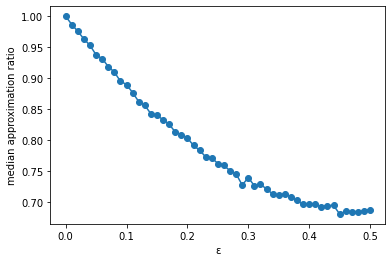

In [20]:
plt.plot(eps, ar_medians, '-o')
plt.xlabel('ɛ')
plt.ylabel('median approximation ratio')
plt.show()

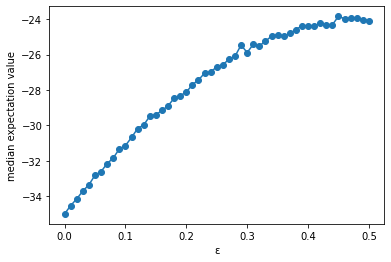

In [21]:
plt.plot(eps, exp_medians, '-o')
plt.xlabel('ɛ')
plt.ylabel('median expectation value')
plt.show()

In [1140]:
df = pd.DataFrame(np.array([eps, exp_medians, ar_medians]).T, columns=['Epsilon', 'Expectation Value', 'Approximation Ratio'])
print(f"Runing {eval_num} evaluations for each ɛ on Simulator - Median")
print()
print(df.to_string(index=False))

Runing 50 evaluations for each ɛ on Simulator - Median

 Epsilon  Expectation Value  Approximation Ratio
    0.00         -35.000000             1.000000
    0.01         -31.651611             0.904332
    0.02         -28.755005             0.821572
    0.03         -26.743286             0.764094
    0.04         -25.482544             0.728073
    0.05         -24.761719             0.707478
    0.06         -24.120361             0.689153
    0.07         -23.800659             0.680019
    0.08         -24.078979             0.687971
    0.09         -24.687256             0.705350
    0.10         -25.376099             0.725031
    0.11         -26.182739             0.748078
    0.12         -27.034302             0.772409
    0.13         -27.989502             0.799700
    0.14         -29.024780             0.829279
    0.15         -29.815186             0.851862
    0.16         -30.752075             0.878631
    0.17         -31.615601             0.903303
    0.18     

## Simulator with NoiseModel

In [10]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

noise_backend = provider.get_backend("ibmq_toronto")
noise_model = NoiseModel.from_backend(noise_backend)
coupling_map = noise_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [11]:
quantum_instance = QuantumInstance(
                                    backend=Aer.get_backend('qasm_simulator'),
                                    noise_model=noise_model,
                                    coupling_map=coupling_map, 
                                    basis_gates=basis_gates,
                                    shots=shots
                                    )

In [12]:
exp_medians = []
ar_medians = []
eps = []

# epsilon from 0 until 0.5 in 50 steps  
for e in range(0,51, 1):
    epsilon = e * 0.01
    temp_exp = []
    temp_ar = []
    
    # execute warmstart qaoa eval_num times for each epsilon 
    for n in (0,eval_num):
        exp, ar = run_ws_qaoa(max_cut, quantum_instance, epsilon=epsilon)
        temp_exp.append(exp)
        temp_ar.append(ar)
    
    # calculate median for expecation values and approximation ratios 
    exp_medians.append(np.median(temp_exp))
    ar_medians.append(np.median(temp_ar))
    eps.append(epsilon)
    
    print(f".", end='')

...................................................

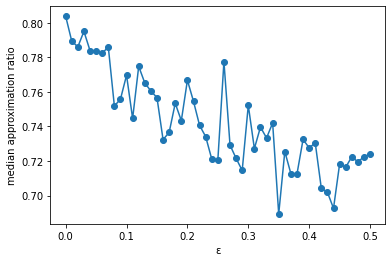

In [13]:
plt.plot(eps, ar_medians, '-o')
plt.xlabel('ɛ')
plt.ylabel('median approximation ratio')
plt.show()

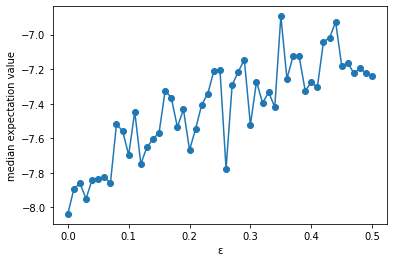

In [14]:
plt.plot(eps, exp_medians, '-o')
plt.xlabel('ɛ')
plt.ylabel('median expectation value')
plt.show()

In [15]:
df = pd.DataFrame(np.array([eps, exp_medians, ar_medians]).T, columns=['Epsilon', 'Expectation Value', 'Approximation Ratio'])
print(f"Runing {eval_num} evaluations for each ɛ on Simulator with Noise Model - Median")
print()
print(df.to_string(index=False))

Runing 100 evaluations for each ɛ on Simulator with Noise Model - Median

 Epsilon  Expectation Value  Approximation Ratio
    0.00          -8.038737             0.803874
    0.01          -7.894206             0.789421
    0.02          -7.861816             0.786182
    0.03          -7.951009             0.795101
    0.04          -7.839844             0.783984
    0.05          -7.835286             0.783529
    0.06          -7.823568             0.782357
    0.07          -7.861816             0.786182
    0.08          -7.518880             0.751888
    0.09          -7.558105             0.755811
    0.10          -7.696940             0.769694
    0.11          -7.446615             0.744661
    0.12          -7.748372             0.774837
    0.13          -7.652018             0.765202
    0.14          -7.605794             0.760579
    0.15          -7.567220             0.756722
    0.16          -7.323893             0.732389
    0.17          -7.365885             0.73